# Handwritten Equation Decipherment (HED)

This notebook shows an implementation of [Handwritten Equation Decipherment](https://proceedings.neurips.cc/paper_files/paper/2019/file/9c19a2aa1d84e04b0bd4bc888792bd1e-Paper.pdf). In this task, the handwritten equations are given, which consist of sequential pictures of characters. The equations are generated with unknown operation rules from images of symbols ('0', '1', '+' and '='), and each equation is associated with a label indicating whether the equation is correct (i.e., positive) or not (i.e., negative). Also, we are given a knowledge base which involves the structure of the equations and a recursive definition of bit-wise operations. The task is to learn from a training set of above mentioned equations and then to predict labels of unseen equations. 

Intuitively, we first use a machine learning model (learning part) to obtain the pseudo-labels ('0', '1', '+' and '=') for the observed pictures. We then use the knowledge base (reasoning part) to perform abductive reasoning so as to yield ground hypotheses as possible explanations to the observed facts, suggesting some pseudo-labels to be revised. This process enables us to further update the machine learning model.

In [ ]:
# Import necessary libraries and modules
import os.path as osp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from examples.hed.datasets import get_dataset, split_equation
from examples.models.nn import SymbolNet
from abl.learning import ABLModel, BasicNN
from examples.hed.reasoning import HedKB, HedReasoner
from abl.data.evaluation import SymbolAccuracy
from examples.hed.consistency_metric import ConsistencyMetric
from abl.utils import ABLLogger, print_log
from examples.hed.bridge import HedBridge

## Working with Data

First, we get the datasets of handwritten equations:

In [ ]:
total_train_data = get_dataset(train=True)
train_data, val_data = split_equation(total_train_data, 3, 1)
test_data = get_dataset(train=False)

The dataset are shown below:

In [ ]:
true_train_equation = train_data[1]
false_train_equation = train_data[0]
print(f"Equations in the dataset is organized by equation length, " +
      f"from {min(train_data[0].keys())} to {max(train_data[0].keys())}")
print()

true_train_equation_with_length_5 = true_train_equation[5]
false_train_equation_with_length_5 = false_train_equation[5]
print(f"For each euqation length, there are {len(true_train_equation_with_length_5)} " +
      f"true equation and {len(false_train_equation_with_length_5)} false equation " +
      f"in the training set")

true_val_equation = val_data[1]
false_val_equation = val_data[0]
true_val_equation_with_length_5 = true_val_equation[5]
false_val_equation_with_length_5 = false_val_equation[5]
print(f"For each euqation length, there are {len(true_val_equation_with_length_5)} " +
      f"true equation and {len(false_val_equation_with_length_5)} false equation " +
      f"in the validation set")

true_test_equation = test_data[1]
false_test_equation = test_data[0]
true_test_equation_with_length_5 = true_test_equation[5]
false_test_equation_with_length_5 = false_test_equation[5]
print(f"For each euqation length, there are {len(true_test_equation_with_length_5)} " +
      f"true equation and {len(false_test_equation_with_length_5)} false equation " +
      f"in the test set")

Equations in the dataset is organized by equation length, from 5 to 26

For each euqation length, there are 225 true equation and 225 false equation in the training set
For each euqation length, there are 75 true equation and 75 false equation in the validation set
For each euqation length, there are 300 true equation and 300 false equation in the test set


As illustrations, we show four equations in the training dataset:

First true equation with length 5 in the training dataset:


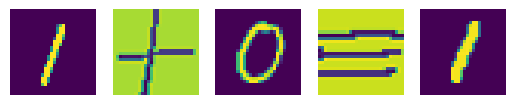

First true equation with length 8 in the training dataset:


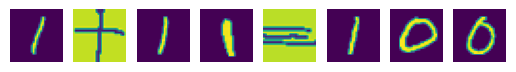

First false equation with length 5 in the training dataset:


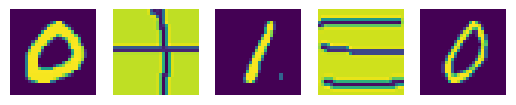

First false equation with length 8 in the training dataset:


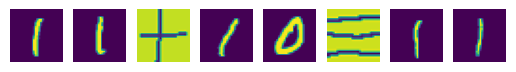

In [ ]:
true_train_equation_with_length_5 = true_train_equation[5]
true_train_equation_with_length_8 = true_train_equation[8]
print(f"First true equation with length 5 in the training dataset:")
for i, x in enumerate(true_train_equation_with_length_5[0]):
    plt.subplot(1, 5, i+1)
    plt.axis('off') 
    plt.imshow(x.transpose(1, 2, 0))
plt.show()
print(f"First true equation with length 8 in the training dataset:")
for i, x in enumerate(true_train_equation_with_length_8[0]):
    plt.subplot(1, 8, i+1)
    plt.axis('off') 
    plt.imshow(x.transpose(1, 2, 0))
plt.show()

false_train_equation_with_length_5 = false_train_equation[5]
false_train_equation_with_length_8 = false_train_equation[8]
print(f"First false equation with length 5 in the training dataset:")
for i, x in enumerate(false_train_equation_with_length_5[0]):
    plt.subplot(1, 5, i+1)
    plt.axis('off') 
    plt.imshow(x.transpose(1, 2, 0))
plt.show()
print(f"First false equation with length 8 in the training dataset:")
for i, x in enumerate(false_train_equation_with_length_8[0]):
    plt.subplot(1, 8, i+1)
    plt.axis('off') 
    plt.imshow(x.transpose(1, 2, 0))
plt.show()

## Building the Learning Part

To build the learning part, we need to first build a machine learning base model. We use SymbolNet, and encapsulate it within a `BasicNN` object to create the base model. `BasicNN` is a class that encapsulates a PyTorch model, transforming it into a base model with an sklearn-style interface. 

In [ ]:
# class of symbol may be one of ['0', '1', '+', '='], total of 4 classes
cls = SymbolNet(num_classes=4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(cls.parameters(), lr=0.001, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    device=device,
    batch_size=32,
    num_epochs=1,
    stop_loss=None,
)

However, the base model built above deals with instance-level data (i.e., individual images), and can not directly deal with example-level data (i.e., a list of images comprising the equation). Therefore, we wrap the base model into `ABLModel`, which enables the learning part to train, test, and predict on example-level data.

In [ ]:
model = ABLModel(base_model)

## Building the Reasoning Part

In the reasoning part, we first build a knowledge base. As mentioned before, the knowledge base in this task involves the structure of the equations and a recursive definition of bit-wise operations. The knowledge base is already defined in `HedKB`, which is derived from `PrologKB`, and is built upon Prolog file `reasoning/BK.pl` and `reasoning/learn_add.pl`.

Specifically, the knowledge about the structure of equations (in `reasoning/BK.pl`) is a set of DCG (definite clause grammar) rules recursively define that a digit is a sequence of '0' and '1', and equations share the structure of X+Y=Z, though the length of X, Y and Z can be varied. The knowledge about bit-wise operations (in `reasoning/learn_add.pl`) is a recursive logic program, which reversely calculates X+Y, i.e., it operates on X and Y digit-by-digit and from the last digit to the first.

Note: Please notice that, the specific rules for calculating the operations are undefined in the knowledge base, i.e., results of '0+0', '0+1' and '1+1' could be '0', '1', '00', '01' or even '10'. The missing calculation rules are required to be learned from the data. Therefore, `HedKB` incorporates methods for abducing rules from data. Users interested can refer to the specific implementation of `HedKB` in `reasoning/reasoning.py`

In [ ]:
kb = HedKB()

Then, we create a reasoner. Due to the indeterminism of abductive reasoning, there could be multiple candidates compatible to the knowledge base. When this happens, reasoner can minimize inconsistencies between the knowledge base and pseudo-labels predicted by the learning part, and then return only one candidate that has the highest consistency. 

In this task, we create the reasoner by instantiating the class `HedReasoner`, which is a reasoner derived from `Reasoner` and tailored specifically for this task. `HedReasoner` leverages [ZOOpt library](https://github.com/polixir/ZOOpt) for acceleration, and has designed a specific strategy to better harness ZOOpt’s capabilities. Additionally, methods for abducing rules from data have been incorporated. Users interested can refer to the specific implementation of `HedReasoner` in `reasoning/reasoning.py`.

In [ ]:
reasoner = HedReasoner(kb, dist_func="hamming", use_zoopt=True, max_revision=10)

## Building Evaluation Metrics

Next, we set up evaluation metrics. These metrics will be used to evaluate the model performance during training and testing. Specifically, we use `SymbolAccuracy` and `ReasoningMetric`, which are used to evaluate the accuracy of the machine learning model’s predictions and the accuracy of the final reasoning results, respectively.

In [ ]:
metric_list = [ConsistencyMetric(kb=kb)]

## Bridge Learning and Reasoning

Now, the last step is to bridge the learning and reasoning part. We proceed this step by creating an instance of `HedBridge`, which is derived from `SimpleBridge` and tailored specific for this task.

In [ ]:
bridge = HedBridge(model, reasoner, metric_list)

Perform training and testing.

**[TODO]** give a detailed introduction about training in HedBridge.

In [ ]:
# Build logger
print_log("Abductive Learning on the HED example.", logger="current")

# Retrieve the directory of the Log file and define the directory for saving the model weights.
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.pretrain(weights_dir)
bridge.train(train_data, val_data)
bridge.test(test_data)